In [1]:
import numpy as np
import pandas as pd
from matplotlib_venn import venn3_unweighted
import matplotlib.pyplot as plt
import os
import csv
from ShareE_analysis import shareE_analysis_atlas
from Subgraph import subgraph

In [35]:
# Get the enhancer atlas relevant to your cell line
E_P = pd.read_csv('enhancer_atlas_MCF-7_EP.txt',sep='\t',header=None)
E_P['enhancer'] = E_P[0].apply(lambda x: x.split('_')[0])
E_P['gene'] = E_P[0].apply(lambda x: x.split('$')[-4])
E_P['chrom'] = E_P[0].apply(lambda x: x.split('$')[-3])
E_P['TSS'] = E_P[0].apply(lambda x: x.split('$')[-2])
E_P['strand'] = E_P[0].apply(lambda x: x.split('$')[-1])
E_P.rename(columns={1: 'predicted score'}, inplace=True)
E_P.drop(columns=[0], inplace=True)
E_P.head()

,predicted score,enhancer,gene,chrom,TSS,strand
0,0.602533,chr1:955750-957580,AL669831.1,chr1,721320,+
1,1.087982,chr1:1132570-1132810,AL669831.1,chr1,721320,+
2,1.283281,chr1:1014690-1017190,AL669831.1,chr1,721320,+
3,2.397889,chr1:955750-957580,NOC2L,chr1,894689,-
4,1.680626,chr1:976260-976550,NOC2L,chr1,894689,-


In [2]:
def get_data(chrom, dataset, resolution, hicthreshold):
    data_root = '/media/rokny/DATA2/michaeldefran/HiCoEx/data/'
    name_coexp = 'coexpression_chr_{}_{}'.format(chrom, chrom)
    name_hic = 'observed_{}_{}_{}'.format(chrom, chrom, resolution)

    mcf7_coexp = np.load('{}{}/coexpression_networks/{}_90.0.npy'.format(data_root, dataset, name_coexp))
    mcf7_hic = np.load('{}{}/chromatin_networks/{}_{}.npy'.format(data_root, dataset, name_hic, hicthreshold))
    degrees = np.nansum(mcf7_hic, axis=0)
    disconnected_nodes_mcf7 = np.ravel(np.argwhere(degrees == 0))
    mcf7_pairs = np.stack(np.where((mcf7_coexp == 1))).T

    mcf7_rna = pd.read_csv('{}{}/rna/expression_info_chr_{}.csv'.format(data_root, dataset,chrom))

    mcf7_dico_pair, mcf7_dico_pairname = [], []
    for u,v in mcf7_pairs:
        if (u not in disconnected_nodes_mcf7) and (v not in disconnected_nodes_mcf7):
            mcf7_dico_pair.append([(u,v),(mcf7_rna.loc[u,'Gene name'], mcf7_rna.loc[v,'Gene name'])])

    mcf7_dif = pd.DataFrame(data=mcf7_dico_pair, columns=['u,v','name'])
    mcf7_dif.loc[:,'u_name'] = np.stack(mcf7_dif['name'])[:,0]
    mcf7_dif.loc[:,'v_name'] = np.stack(mcf7_dif['name'])[:,1]
    
    pair_list = mcf7_dif['u,v'].values
    r, c = np.stack(pair_list).T
    pair_list_11 = pair_list[(mcf7_hic[r,c] == 1) & (mcf7_coexp[r,c] == 1)]
    
    return pair_list_11, mcf7_rna, mcf7_hic, mcf7_coexp, mcf7_dif

In [3]:
def get_localdict(hic, pair_list):
    hic = np.triu(hic, 1)
    hic = hic + hic.T
    hic = np.nan_to_num(hic)
    graph = np.stack(np.where(hic > 0))
    
    pair_list = np.stack(pair_list)
    local_dict = {}
    for i in range(0, len(pair_list)):
        pair = pair_list[i,:]
        local_graph = subgraph(graph, pair)
#         ipdb.set_trace()
        idx = np.where((local_graph[0,:]==pair[0])|(local_graph[0,:]==pair[1]))[0]
        local_graph = local_graph[:,idx]
                
        local_dict[tuple(pair)] = local_graph.T
    return local_dict

In [4]:
def get_localnei_random(local_dict, pair_list_11, mcf7_rna, union=False, num_nei=10):
    shared_nodes = []
    for i in range(len(pair_list_11)):
        u,v = pair_list_11[i]
        neighbor_pairs = local_dict[(u,v)]
        n1 = neighbor_pairs[np.where(neighbor_pairs == pair_list_11[i][0])[0]]
        n2 = neighbor_pairs[np.where(neighbor_pairs == pair_list_11[i][1])[0]]
        if union:
            s = np.union1d(n1, n2)
        else:
            s = np.intersect1d(n1, n2)
        shared_nodes.append(s.tolist())

    signifi_shared = [[i,s] for i,s in enumerate(shared_nodes) if len(s)-2 >= num_nei]
    signifi_genes = [mcf7_rna.loc[s, 'Gene name'].values for s in shared_nodes if len(s)-2 >= num_nei]
    return signifi_shared, signifi_genes

In [108]:
# chrom = '17'
# dataset = 'muscle'
# resolution = 5000
# hicthres = 80.0
# pair_list_11, mcf7_rna, mcf7_hic, mcf7_coexp, mcf7_dif = get_data(chrom, dataset, resolution, hicthres)
# local_dict = get_localdict(mcf7_hic, pair_list_11)
# signifi_shared, signifi_genes = get_localnei_random(local_dict, pair_list_11, mcf7_rna, union=False, num_nei=10)
# share_all, x1 = shareE_analysis_atlas(chrom, E_P, 
#                                              signifi_shared, signifi_genes, 
#                                              pair_list_11, local_dict, 
#                                              mcf7_rna, mcf7_coexp, random=False, skip=False)
# my_dict = share_all[1]
# musclepairs = set(my_dict.keys())
# with open(f'{dataset}_{chrom}_subgraph.csv', 'w') as f:
#     for key in my_dict.keys():
#         f.write("%s,%s\n"%(key, my_dict[key]))

# print("done")

done


When extracting the data from share_all, take note of how it is presented:

shared_dict_all = {}  **all common neighbors, attention, and co-exp labels**

share_dict = {}       **common neighbors in shared_dict_all**

share_dict_E = {}     **enhancers shared by neighbors and genes**

share_dict_gene = {}  **the set of all gene-neighbors that share same enhancer in share_dict_E with a gene or both two genes**

share_dict_itset = {}  **neighbor set that shared enhancers with both of two genes**

share_itset_nei = {}

In [37]:
chrom = '17'
dataset = 'breast_cancer'
resolution = 40000
hicthres = 80.0
pair_list_11, mcf7_rna, mcf7_hic, mcf7_coexp, mcf7_dif = get_data(chrom, dataset, resolution, hicthres)
local_dict = get_localdict(mcf7_hic, pair_list_11)
signifi_shared, signifi_genes = get_localnei_random(local_dict, pair_list_11, mcf7_rna, union=False, num_nei=10)
share_all, x1 = shareE_analysis_atlas(chrom, E_P, 
                                             signifi_shared, signifi_genes, 
                                             pair_list_11, local_dict, 
                                             mcf7_rna, mcf7_coexp, random=False, skip=False)
my_dict = share_all[1]
print(my_dict)
with open(f'{dataset}_{chrom}_subgraph.csv', 'w') as f:
    for key in my_dict.keys():
        f.write("%s,%s\n"%(key, my_dict[key]))

{('INPP5K', 'PITPNA'): ['TUSC5', 'YWHAE', 'CRK', 'MYO1C', 'SLC43A2', 'SCARF1', 'RILP', 'WDR81', 'SGSM2', 'TSR1'], ('WDR81', 'SERPINF2'): ['SLC43A2', 'SCARF1', 'RILP', 'PRPF8', 'RPA1', 'SMYD4', 'RTN4RL1', 'DPH1', 'OVCA2', 'HIC1'], ('WDR81', 'SERPINF1'): ['SLC43A2', 'SCARF1', 'RILP', 'PRPF8', 'RPA1', 'SMYD4', 'RTN4RL1', 'DPH1', 'OVCA2', 'HIC1'], ('WDR81', 'SMYD4'): ['PITPNA', 'SLC43A2', 'SCARF1', 'RILP', 'SERPINF2', 'SERPINF1', 'RTN4RL1', 'DPH1', 'OVCA2', 'HIC1'], ('PELP1', 'ZMYND15'): ['SPNS2', 'MYBBP1A', 'GGT6', 'ALOX15', 'VMO1', 'PSMB6', 'PLD2', 'CAMTA2', 'INCA1', 'KIF1C'], ('PELP1', 'VMO1'): ['MYBBP1A', 'GGT6', 'ALOX15', 'CXCL16', 'ZMYND15', 'RNF167', 'SLC25A11', 'ENO3', 'PFN1', 'SPAG7'], ('PELP1', 'PSMB6'): ['MYBBP1A', 'GGT6', 'ALOX15', 'CXCL16', 'ZMYND15', 'RNF167', 'SLC25A11', 'ENO3', 'PFN1', 'SPAG7'], ('PELP1', 'PLD2'): ['MYBBP1A', 'GGT6', 'ALOX15', 'CXCL16', 'ZMYND15', 'RNF167', 'SLC25A11', 'ENO3', 'PFN1', 'SPAG7'], ('ARRB2', 'CXCL16'): ['SPNS2', 'MYBBP1A', 'GGT6', 'ALOX15', 'VM

In [33]:
chrom = '14'
dataset = 'maxhicmuscle'
resolution = 5000
hicthres = 0.0
pair_list_11, mcf7_rna, mcf7_hic, mcf7_coexp, mcf7_dif = get_data(chrom, dataset, resolution, hicthres)
local_dict = get_localdict(mcf7_hic, pair_list_11)
signifi_shared, signifi_genes = get_localnei_random(local_dict, pair_list_11, mcf7_rna, union=False, num_nei=1)
share_all, x1 = shareE_analysis_atlas(chrom, E_P, 
                                             signifi_shared, signifi_genes, 
                                             pair_list_11, local_dict, 
                                             mcf7_rna, mcf7_coexp, random=False, skip=False)
my_dict = share_all[1]
print(my_dict)
with open(f'{dataset}_{chrom}_subgraph.csv', 'w') as f:
    for key in my_dict.keys():
        f.write("%s,%s\n"%(key, my_dict[key]))

{('METTL17', 'ARHGEF40'): ['ZNF219', 'LTB4R'], ('ARHGEF40', 'ZNF219'): ['METTL17', 'RNASE13'], ('NDRG2', 'ZNF219'): ['METTL17', 'RNASE13']}


In [8]:
dataset = 'muscle'
resolution = 5000
hicthres = 80.0
musclepairs = set()
for chr in range(1, 23):
    print(f'starting chrom {chr}')
    pair_list_11, mcf7_rna, mcf7_hic, mcf7_coexp, mcf7_dif = get_data(str(chr), dataset, resolution, hicthres)
    local_dict = get_localdict(mcf7_hic, pair_list_11)
    signifi_shared, signifi_genes = get_localnei_random(local_dict, pair_list_11, mcf7_rna, union=False, num_nei=10)
    share_all, x1 = shareE_analysis_atlas(str(chr), E_P, 
                                             signifi_shared, signifi_genes, 
                                             pair_list_11, local_dict, 
                                             mcf7_rna, mcf7_coexp, random=False, skip=False)
    my_dict = share_all[1]
    musclepairs.update(set(my_dict.keys()))
print('done norm')

starting chrom 1
starting chrom 2
starting chrom 3
starting chrom 4
starting chrom 5
starting chrom 6
starting chrom 7
starting chrom 8
starting chrom 9
starting chrom 10
starting chrom 11
starting chrom 12
starting chrom 13
starting chrom 14
starting chrom 15
starting chrom 16
starting chrom 17
starting chrom 18
starting chrom 19
starting chrom 20
starting chrom 21
starting chrom 22
done norm


In [9]:
dataset = 'maxhicmuscle'
resolution = 5000
hicthres = 0.0
maxhicmusclepairs005 = set()
for chr in range(1, 23):
    print(f'starting chrom {chr}')
    pair_list_11, mcf7_rna, mcf7_hic, mcf7_coexp, mcf7_dif = get_data(str(chr), dataset, resolution, hicthres)
    local_dict = get_localdict(mcf7_hic, pair_list_11)
    signifi_shared, signifi_genes = get_localnei_random(local_dict, pair_list_11, mcf7_rna, union=False, num_nei=1)
    share_all, x1 = shareE_analysis_atlas(str(chr), E_P, 
                                             signifi_shared, signifi_genes, 
                                             pair_list_11, local_dict, 
                                             mcf7_rna, mcf7_coexp, random=False, skip=False)
    my_dict = share_all[1]
    maxhicmusclepairs005.update(set(my_dict.keys()))
print('done maxhic 0.05')

starting chrom 1
starting chrom 2
starting chrom 3
starting chrom 4
starting chrom 5
starting chrom 6
starting chrom 7
starting chrom 8
starting chrom 9
starting chrom 10
starting chrom 11
starting chrom 12
starting chrom 13
starting chrom 14
starting chrom 15
starting chrom 16
starting chrom 17
starting chrom 18
starting chrom 19
starting chrom 20
starting chrom 21
starting chrom 22
done maxhic 0.05


In [10]:
dataset = 'maxhicmuscle0.01'
failedchroms = [13]
resolution = 5000
hicthres = 0.0
maxhicmusclepairs001 = set()
for chr in range(1, 23):
    print(f'starting chrom {chr}')
    try:  
        pair_list_11, mcf7_rna, mcf7_hic, mcf7_coexp, mcf7_dif = get_data(str(chr), dataset, resolution, hicthres)
        local_dict = get_localdict(mcf7_hic, pair_list_11)
        signifi_shared, signifi_genes = get_localnei_random(local_dict, pair_list_11, mcf7_rna, union=False, num_nei=1)
        share_all, x1 = shareE_analysis_atlas(str(chr), E_P, 
                                                 signifi_shared, signifi_genes, 
                                                 pair_list_11, local_dict, 
                                                 mcf7_rna, mcf7_coexp, random=False, skip=False)
        my_dict = share_all[1]
        maxhicmusclepairs001.update(set(my_dict.keys()))
    except ValueError:
        continue
print('done maxhic 0.01')

starting chrom 1
starting chrom 2
starting chrom 3
starting chrom 4
starting chrom 5
starting chrom 6
starting chrom 7
starting chrom 8
starting chrom 9
starting chrom 10
starting chrom 11
starting chrom 12
starting chrom 13
starting chrom 14
starting chrom 15
starting chrom 16
starting chrom 17
starting chrom 18
starting chrom 19
starting chrom 20
starting chrom 21
starting chrom 22
done maxhic 0.01


In [12]:
dataset = 'maxhicmuscle0.001'
failedchroms = [13]
resolution = 5000
hicthres = 0.0
maxhicmusclepairs0001 = set()
for chr in range(1, 23):
    print(f'starting chrom {chr}')
    try:  
        pair_list_11, mcf7_rna, mcf7_hic, mcf7_coexp, mcf7_dif = get_data(str(chr), dataset, resolution, hicthres)
        local_dict = get_localdict(mcf7_hic, pair_list_11)
        signifi_shared, signifi_genes = get_localnei_random(local_dict, pair_list_11, mcf7_rna, union=False, num_nei=1)
        share_all, x1 = shareE_analysis_atlas(str(chr), E_P, 
                                                 signifi_shared, signifi_genes, 
                                                 pair_list_11, local_dict, 
                                                 mcf7_rna, mcf7_coexp, random=False, skip=False)
        my_dict = share_all[1]
        maxhicmusclepairs0001.update(set(my_dict.keys()))
    except ValueError:
        continue
print('done maxhic 0.001')
print(maxhicmusclepairs0001)

starting chrom 1
starting chrom 2
starting chrom 3
starting chrom 4
starting chrom 5
starting chrom 6
starting chrom 7
starting chrom 8
starting chrom 9
starting chrom 10
starting chrom 11
starting chrom 12
starting chrom 13
starting chrom 14
starting chrom 15
starting chrom 16
starting chrom 17
starting chrom 18
starting chrom 19
starting chrom 20
starting chrom 21
starting chrom 22
done maxhic 0.001
{('NEAT1', 'MALAT1'), ('CHRNB1', 'SENP3')}


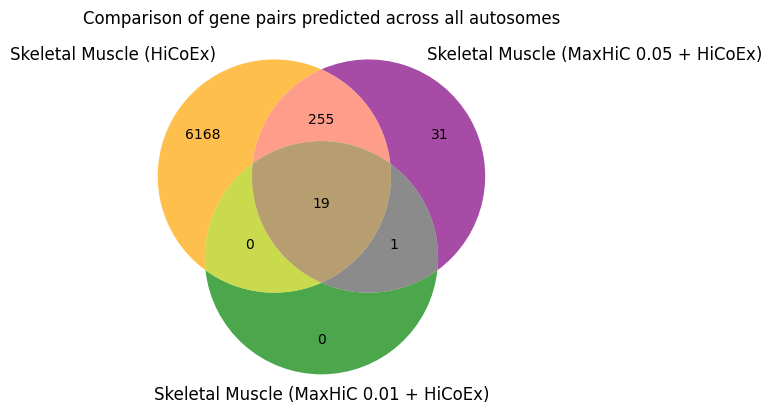

<Figure size 640x480 with 0 Axes>

In [15]:
venn3_unweighted([musclepairs, maxhicmusclepairs005, maxhicmusclepairs001], 
      set_labels=('Skeletal Muscle (HiCoEx)', 'Skeletal Muscle (MaxHiC 0.05 + HiCoEx)', 'Skeletal Muscle (MaxHiC 0.01 + HiCoEx)'),
      set_colors=("orange", "purple", "green"), alpha=0.7)
plt.title("Comparison of gene pairs predicted across all autosomes")  
plt.show()
plt.savefig('genepairs.png')

In [20]:
print(maxhicmusclepairs)

{('MICB', 'AIF1'), ('KAT5', 'AP5B1'), ('ELMO3', 'SLC9A5'), ('CSNK2B', 'C6orf48'), ('BAZ2A', 'NACA'), ('KCTD11', 'TNFSF13'), ('LY6G5B', 'C6orf48'), ('CHRNB1', 'SENP3'), ('MAP7D1', 'STK40'), ('KCTD11', 'MPDU1'), ('CCDC142', 'HTRA2'), ('RP11-582J16.5', 'BIN3'), ('TBC1D10A', 'SEC14L2'), ('CSAD', 'C12orf10'), ('RUVBL2', 'PPFIA3'), ('CDK9', 'ST6GALNAC6'), ('PCDHGA11', 'PCDHGC5'), ('ZNF747', 'ZNF689'), ('MOGS', 'CCDC142'), ('TPP1', 'MRPL17'), ('ARFGAP2', 'MADD'), ('GRINA', 'GPAA1'), ('CTD-3184A7.4', 'LIME1'), ('ZFAND2B', 'DNPEP'), ('FRMD8', 'MALAT1'), ('SF3B2', 'KLC2'), ('RNASEH2C', 'DRAP1'), ('MUTYH', 'NASP'), ('SART1', 'EIF1AD'), ('CLK2', 'RUSC1'), ('NDRG2', 'ZNF219'), ('MICB', 'DDX39B'), ('TTC31', 'AUP1'), ('RXRB', 'ZBTB22'), ('PPP1R16A', 'CTD-2517M22.14'), ('SLC52A2', 'C8orf82'), ('IGFBP4', 'CCR7'), ('DNPEP', 'GMPPA'), ('MSH5', 'SKIV2L'), ('DVL2', 'CD68'), ('GABARAP', 'GPS2'), ('SSSCA1', 'CFL1'), ('GATAD2B', 'SLC39A1'), ('PSMB6', 'RNF167'), ('CBFB', 'TRADD'), ('FAM96B', 'C16orf70'), ('NOS

In [36]:
dataset = 'maxhicmuscle0.001'
resolution = 5000
hicthres = 0.0
maxhicmusclepairs1 = []
for chr in range(1, 23):
    print(f'starting chrom {chr}')
    pair_list_11, mcf7_rna, mcf7_hic, mcf7_coexp, mcf7_dif = get_data(str(chr), dataset, resolution, hicthres)
    local_dict = get_localdict(mcf7_hic, pair_list_11)
    signifi_shared, signifi_genes = get_localnei_random(local_dict, pair_list_11, mcf7_rna, union=False, num_nei=1)
    share_all, x1 = shareE_analysis_atlas(str(chr), E_P, 
                                             signifi_shared, signifi_genes, 
                                             pair_list_11, local_dict, 
                                             mcf7_rna, mcf7_coexp, random=False, skip=False)
    maxhicmusclepairs1.append(share_all[1])
print('done maxhic')
print(maxhicmusclepairs1)

starting chrom 1
starting chrom 2
starting chrom 3
starting chrom 4


ValueError: need at least one array to stack